In [29]:
import requests
from pathlib import Path
import io
import zipfile
import os
import pandas as pd
import shutil
from pydantic import BaseModel
from typing import Dict, List, Optional, Any
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
from PIL import Image
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
from typing import List, Dict
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
from transformers import AutoModelForSequenceClassification
import accelerate
import transformers
from transformers import DistilBertConfig, DistilBertModel, DistilBertTokenizerFast
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer


/home/ubuntu/MiniCLIP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
flicker_dir = Path("../data/flicker")
augmented_dir = Path("../data/augmented")

flicker_dir.mkdir(parents=True, exist_ok=True)
augmented_dir.mkdir(parents=True, exist_ok=True)

In [31]:
# '''Get dataset from flicker'''
# url = "https://www.lirmm.fr/~poncelet/Ressources/flickr_subset2.zip"
# print("Requesting...\n")
# response = requests.get(url)
# if response.status_code == 200:
#     print("Téléchargement réussi. Extraction...")
#     with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
#         # Extraire sans ajouter de sous-dossier supplémentaire
#         for member in zip_ref.namelist():
#             # Corrige les chemins pour ignorer un éventuel prefixe flickr_subset2/
#             member_path = member
#             if member.startswith("flickr_subset2/"):
#                 member_path = member[len("flickr_subset2/"):]
#             target_path = flicker_dir / member_path

#             # Si c'est un répertoire, on le crée
#             if member.endswith("/"):
#                 target_path.mkdir(exist_ok=True, parents=True)
#             else:
#                 os.makedirs(os.path.dirname(target_path), exist_ok=True)
#                 with zip_ref.open(member) as source, open(target_path, "wb") as target:
#                     target.write(source.read())
#     print(f"Données extraites dans : {flicker_dir}")
# else:
#     print("Échec du téléchargement. Code HTTP :", response.status_code)


In [32]:
!ls ..

'FineTuneBERT (1).ipynb'   data   main.py     pyproject.toml
 README.md		   figs   notebooks   uv.lock


In [33]:
metadata_path = Path("../data/augmented/metadata.csv")
df = pd.read_csv(metadata_path)
print(df.columns)
print(df.iloc[0])

Index(['image_path', 'label', 'caption'], dtype='object')
image_path                                        water_070.jpg
label                                               Label.WATER
caption       A kayaker wearing a blue wetsuit and black hel...
Name: 0, dtype: object


In [34]:
def get_label(filename: str):
    return filename.split("_")[0]


def get_uuid(filename: str):
    name = Path(filename).stem          
    parts = name.split("_")
    return "_".join(parts[:2])          


def build_augmented_path(img_path: Path, base_dir: Path):
    img_path = Path(img_path)
    filename = img_path.name
    label = get_label(filename)
    uuid = get_uuid(filename)
    print(uuid)

    return base_dir / label / uuid / filename

get_label(df["image_path"].iloc[1])
get_uuid(df["image_path"].iloc[1])

print(build_augmented_path(df["image_path"].iloc[1], augmented_dir))

water_070
../data/augmented/water/water_070/water_070_spatial.jpg


In [35]:
from torchvision import transforms

transform = transforms.Compose(
    [transforms.Resize((300, 500)),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class ImageCLIPDataset(Dataset):
    def __init__(self, imgs, labels, base_dir: Path, transform):
        self.img_paths = [Path(build_augmented_path(img, base_dir)) for img in imgs]
        self.labels = labels
        self.transform = transform
        self.classes = sorted(set(self.labels))                  
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}  



    def __getitem__(self, idx) -> Tuple[Image.Image, str]:
        img = Image.open(self.img_paths[idx]).convert("RGB")
        label_str = self.labels[idx]
        label = self.class_to_idx[label_str]   

        if self.transform:
            img = self.transform(img)
        return idx, img, label
    
    def __len__(self) -> int:
        return len(self.img_paths)
    
    def _get_img_path_from_idx(self, idx: int) -> Path:
        return self.img_paths[idx]
    
    def _get_label_from_idx(self, idx: int) -> str :
        return self.labels[idx]
    
    def _get_img_size(self, idx: int) -> Tuple[int, int]:
        img = Image.open(self.img_paths[idx]).convert("RGB")
        if self.transform:
            for t in self.transform.transforms:
                if isinstance(t, transforms.Resize):
                    img = t(img)
        return img.height, img.width

    
    
    

        


In [36]:
X =  df["image_path"]
print(X)

0               water_070.jpg
1       water_070_spatial.jpg
2         water_070_color.jpg
3               water_084.jpg
4       water_084_spatial.jpg
                ...          
1795     ball_008_spatial.jpg
1796       ball_008_color.jpg
1797             ball_030.jpg
1798     ball_030_spatial.jpg
1799       ball_030_color.jpg
Name: image_path, Length: 1800, dtype: object


In [37]:

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=11)
df_test, df_val = train_test_split(df_temp, test_size=0.5, random_state=11)

print(len(df_train), len(df_test), len(df_val))
print(df_train["label"].value_counts(normalize=True) * 100)
print(df_val["label"].value_counts(normalize=True) * 100)
print(df_test["label"].value_counts(normalize=True) * 100)


1260 270 270
label
Label.BALL     25.873016
Label.BIKE     25.476190
Label.WATER    24.682540
Label.DOG      23.968254
Name: proportion, dtype: float64
label
Label.DOG      29.259259
Label.WATER    24.814815
Label.BIKE     23.333333
Label.BALL     22.592593
Name: proportion, dtype: float64
label
Label.WATER    26.666667
Label.DOG      25.555556
Label.BIKE     24.444444
Label.BALL     23.333333
Name: proportion, dtype: float64


In [38]:
X_train, y_train = df_train["image_path"], df_train["label"]
X_val, y_val     = df_val["image_path"], df_val["label"]
X_test, y_test   = df_test["image_path"], df_test["label"]


In [39]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [40]:
train_dataset = ImageCLIPDataset(X_train, y_train, augmented_dir, transform_resnet)
val_dataset   = ImageCLIPDataset(X_val, y_val, augmented_dir, transform_resnet)
test_dataset  = ImageCLIPDataset(X_test, y_test, augmented_dir, transform_resnet)


water_139
bike_046
bike_067
dog_014
ball_029
dog_062
bike_007
dog_103
ball_113
ball_020
dog_136
water_064
ball_052
water_093
ball_023
water_008
bike_082
water_014
dog_018
dog_033
water_050
dog_017
bike_014
bike_147
bike_019
water_093
dog_034
ball_019
ball_056
water_056
ball_085
ball_107
ball_099
water_141
dog_087
dog_035
ball_055
bike_096
bike_094
water_012
dog_084
bike_071
water_074
bike_048
water_039
water_045
bike_023
water_029
dog_024
bike_141
dog_013
bike_013
water_092
water_050
water_065
ball_128
dog_077
ball_140
bike_085
water_133
ball_101
ball_043
water_060
dog_050
dog_015
water_075
bike_057
ball_008
dog_004
ball_082
water_028
dog_026
dog_091
bike_115
ball_132
water_072
dog_102
bike_078
bike_074
bike_118
bike_085
water_023
bike_086
water_062
dog_019
dog_033
ball_035
dog_095
bike_139
dog_053
water_084
bike_087
water_081
bike_012
bike_008
ball_030
bike_068
bike_042
bike_084
ball_053
ball_131
water_143
bike_024
bike_063
water_075
dog_122
bike_136
dog_054
dog_049
bike_090
dog_026
d

(224, 224)
(224, 224)
dog_014


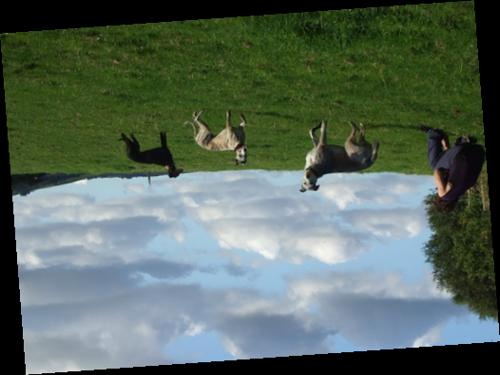

(3, tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ...

In [41]:
print(train_dataset._get_img_size(3))
print(train_dataset._get_img_size(13))
img = train_dataset._get_img_path_from_idx(3)
lg = Image.open(build_augmented_path(img, augmented_dir))
display(lg)
print(train_dataset.__getitem__(3))

In [42]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [43]:
class CNNBasic(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2,2)
        )

        self.flattened_size = self._get_flattened_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 300, 500)
            x = self.features(x)
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [44]:
model = CNNBasic(4)

In [45]:
model

CNNBasic(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=146816, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [47]:
print(len(train_dataset))
print(len(test_dataset))

1260
270


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)
EPOCHS = 11

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    loop = tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch+1}/10 [TRAIN]")
    for i, data in loop:
        idx, inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=running_loss/(i+1))

    avg_train_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} - Average TRAIN loss: {avg_train_loss:.4f}")


    model.eval()
    running_test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/10 [EVAL]")
        for idx, inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = running_test_loss / len(test_loader)
    print(f"Epoch {epoch+1} - Average TEST loss: {avg_test_loss:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=3))




Epoch 1/10 [TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x50176 and 146816x256)

In [56]:
from torchvision.models import resnet18, ResNet18_Weights
num_classes = 4

model_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
model.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # <--- ajoute compatibilité toutes tailles

model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-4, weight_decay=1e-5)



In [57]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0

    for idx, inputs, labels in tqdm(loader, desc="TRAIN", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


def evaluate(model, loader, name="VALID"):
    model.eval()
    preds, targets = [], []
    running_loss = 0.0

    with torch.no_grad():
        for idx, inputs, labels in tqdm(loader, desc=name, leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = outputs.argmax(dim=1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    print(f"\n{name} loss: {avg_loss:.4f}")
    print(f"{name} classification report:\n",
          classification_report(targets, preds, digits=3))

    return avg_loss


# ============================================
# Training Loop
# ============================================
EPOCHS = 11  # à ajuster
for epoch in range(1, EPOCHS + 1):
    print(f"\n========== Epoch {epoch}/{EPOCHS} ==========")
    train_loss = train_one_epoch(model_resnet, train_loader)
    print(f"Train loss: {train_loss:.4f}")
    evaluate(model_resnet, val_loader)


========== Epoch 1/11 ==========


Train loss: 0.6929



VALID loss: 0.4023


NameError: name 'classification_report' is not defined

In [58]:
class ResNet18EarlyExit(nn.Module):
    def __init__(self, num_classes=4, threshold=0.9):
        super().__init__()
        self.threshold = threshold

        base = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.stem = nn.Sequential(
            base.conv1, base.bn1, base.relu, base.maxpool
        )
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        
        self.exit1 = self._make_exit(64, num_classes)
        self.exit2 = self._make_exit(128, num_classes)
        self.exit3 = self._make_exit(256, num_classes)
        self.exit4 = nn.Linear(base.fc.in_features, num_classes)

    def _make_exit(self, channels, num_classes):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(channels, num_classes)
        )
    def extract_features(self, x):
        features = {}

        x = self.stem(x)
        x = self.layer1(x)
        f1 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit1"] = f1

        x = self.layer2(x)
        f2 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit2"] = f2

        x = self.layer3(x)
        f3 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit3"] = f3

        x = self.layer4(x)
        f4 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit4"] = f4

        return features
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        out1 = self.exit1(x)
        if self._confident(out1):
            return out1
        
        x = self.layer2(x)
        out2 = self.exit2(x)
        if self._confident(out2):
            return out2
        
        x = self.layer3(x)
        out3 = self.exit3(x)
        if self._confident(out3):
            return out3
        
        x = self.layer4(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = torch.flatten(x, 1)
        out4 = self.exit4(x)
        return out4, 4

    def _confident(self, logits):
        probs = logits.softmax(dim=1)
        max_conf = probs.max(dim=1).values
        return (max_conf > self.threshold).any()


In [59]:
model_resnet_custom = ResNet18EarlyExit()
model_resnet_custom = model_resnet_custom.to(device)

In [60]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet_custom.parameters(), lr=1e-4, weight_decay=1e-5)

for epoch in range(5):
    model_resnet_custom.train()
    running_loss = 0.0
    for idx, inputs, labels in tqdm(train_loader, desc=f"TRAIN {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model_resnet_custom(inputs)

        if isinstance(output, tuple):
            logits = output[0]
        else:
            logits = output

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}: Train loss = {running_loss/len(train_loader):.4f}")


TRAIN 1: 100%|██████████| 40/40 [00:07<00:00,  5.21it/s]


Epoch 1: Train loss = 0.7111


TRAIN 2: 100%|██████████| 40/40 [00:07<00:00,  5.23it/s]


Epoch 2: Train loss = 0.1220


TRAIN 3: 100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Epoch 3: Train loss = 0.0349


TRAIN 4: 100%|██████████| 40/40 [00:07<00:00,  5.20it/s]


Epoch 4: Train loss = 0.0178


TRAIN 5: 100%|██████████| 40/40 [00:07<00:00,  5.24it/s]

Epoch 5: Train loss = 0.0080


In [61]:
def predict_image(model, img_tensor, class_names):
    model.eval()
    with torch.no_grad():
        logits, exit_id = model(img_tensor.unsqueeze(0).to(device))
        probs = logits.softmax(dim=1)
        confidence, pred = torch.max(probs, dim=1)
        return class_names[pred.item()], confidence.item(), exit_id

img, label = val_dataset[0][1], val_dataset[0][2]  

print(val_dataset._get_label_from_idx(0))

class_names = ["Label.BALL", "Label.BIKE", "Label.DOG", "Label.WATER"]

pred, conf, exit_used = predict_image(model_resnet_custom, img, class_names)
print("Prediction:", pred)
print("Confidence:", round(conf, 3))
print("Exit used:", exit_used)


Label.DOG
Prediction: Label.DOG
Confidence: 0.964
Exit used: 4


In [67]:

from sklearn.metrics import classification_report


def evaluate(model, loader, name="VAL"):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    eval_loss = 0.0

    with torch.no_grad():
        for idx, inputs, labels in tqdm(loader, desc=f"{name}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            output = model(inputs)
            if isinstance(output, torch.Tensor):
                print("hello")
                logits = output
            elif isinstance(output, (list, tuple)):
                logits = next((o for o in output if isinstance(o, torch.Tensor)), None)

            logits = output[0] if isinstance(output, tuple) else output

            loss = criterion(logits, labels)
            eval_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = eval_loss / len(loader)
    print(f"\n{name} Loss: {avg_loss:.4f}")
    print(f"{name} Classification Report:\n",
          classification_report(all_labels, all_preds, digits=3))

    return avg_loss, all_labels, all_probs


In [68]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
_, y_true, y_prob = evaluate(model_resnet_custom, val_loader, name="TEST")

# Classes (assure-toi que l'ordre correspond à l'entraînement)
class_names = ["Label.BALL", "Label.BIKE", "Label.WATER", "Label.DOG"]
n_classes = len(class_names)

# Binarisation One-vs-Rest
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
y_prob = np.array(y_prob)

# ROC par classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


TEST Loss: 0.2353
TEST Classification Report:
               precision    recall  f1-score   support

           0      0.982     0.885     0.931        61
           1      0.938     0.952     0.945        63
           2      0.855     0.899     0.877        79
           3      0.912     0.925     0.919        67

    accuracy                          0.915       270
   macro avg      0.922     0.915     0.918       270
weighted avg      0.917     0.915     0.915       270



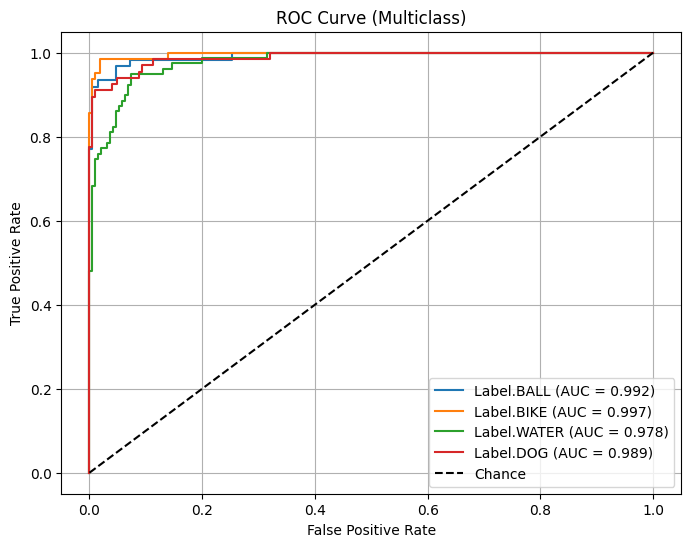

In [69]:
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



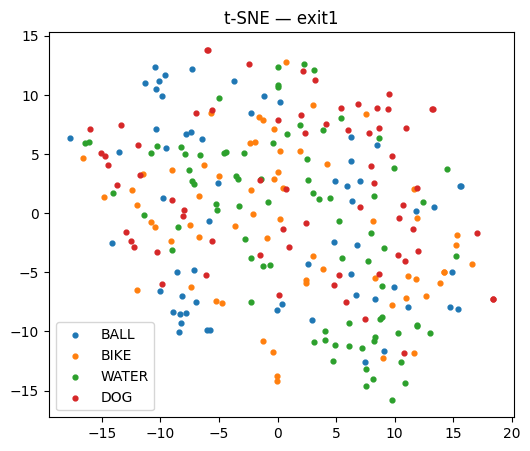

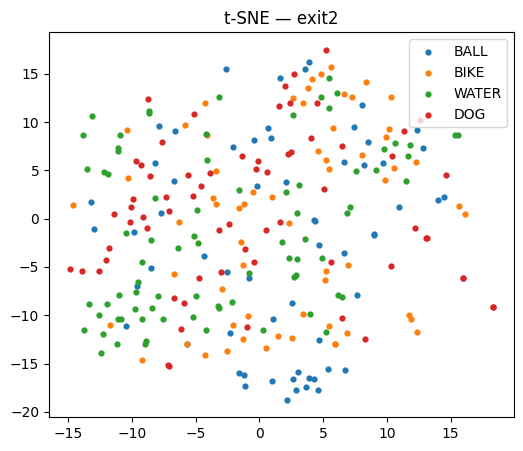

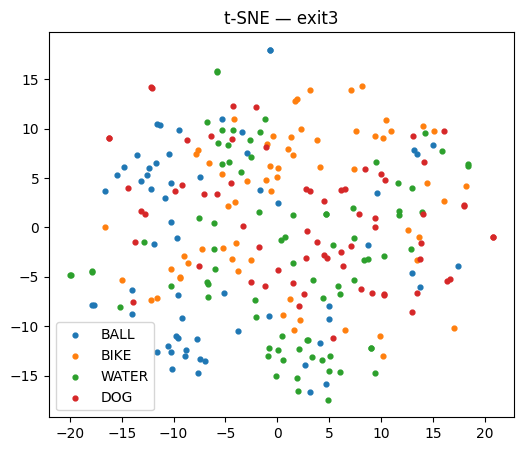

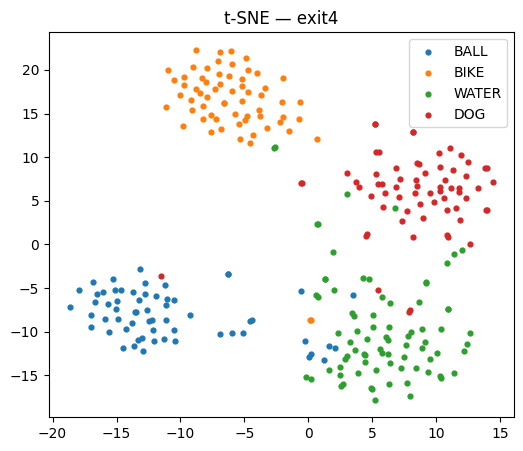

In [70]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(model, loader, class_names, max_samples=500):
    model.eval()
    feats = { "exit1": [], "exit2": [], "exit3": [], "exit4": [] }
    labels = []

    with torch.no_grad():
        for _, (idx, imgs, y) in enumerate(loader):
            imgs = imgs.to(device)

            features = model.extract_features(imgs)
            for k in feats.keys():
                feats[k].append(features[k].cpu().numpy())

            labels.append(y.numpy())
            if len(labels) * imgs.size(0) > max_samples:
                break

    for k in feats.keys():
        X = np.concatenate(feats[k], axis=0)
        Y = np.concatenate(labels, axis=0)

        X_2d = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(X)

        plt.figure(figsize=(6,5))
        for i, class_name in enumerate(class_names):
            pts = X_2d[Y == i]
            plt.scatter(pts[:,0], pts[:,1], s=12, label=class_name)

        plt.title(f"t-SNE — {k}")
        plt.legend()
        plt.show()

class_names = ["BALL", "BIKE", "WATER", "DOG"]
plot_tsne(model_resnet_custom, val_loader, class_names)
